<a href="https://colab.research.google.com/github/ManojithBhat/Fed-learning-chem/blob/main/TEP_One_Class_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pyreadr
import pyreadr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Only Training data is used

df_FaultFree = pyreadr.read_r('/content/drive/My Drive/Colab Notebooks/TEP/TEP_FaultFree_Training.RData')['fault_free_training']
df_Faulty = pyreadr.read_r('/content/drive/My Drive/Colab Notebooks/TEP/TEP_Faulty_Training.RData')['faulty_training']

In [8]:
DF = pd.concat([df_FaultFree,df_Faulty]) # Join both fault free and faulty dataset
DF.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


# Scale the Dataset

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
fault_free = DF[DF['faultNumber']==0].iloc[::50,3:]

fault_free_scaled = sc.fit_transform(fault_free)

# One class SVM algorithm

In [10]:
from sklearn import svm

# Define the OneClass SVM
OneClassSVM = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.01)

# Fit OneClass SVM model
OneClassSVM .fit(fault_free_scaled)

OneClassSVM(gamma=0.01, nu=0.05)

# Visualize the Distance of Fault free data from centre

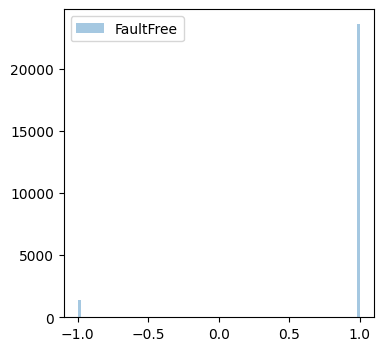

In [11]:
df = DF[DF['faultNumber']==0].iloc[::10,3:]
df_sc = sc.transform(df)

FaultFree_dist=OneClassSVM.predict(df_sc)

plt.rcParams['figure.figsize'] = [4, 4]
plt.hist(FaultFree_dist, bins=100,label='FaultFree',alpha=0.4)
plt.legend()
plt.show()

# Realtime Fault detection

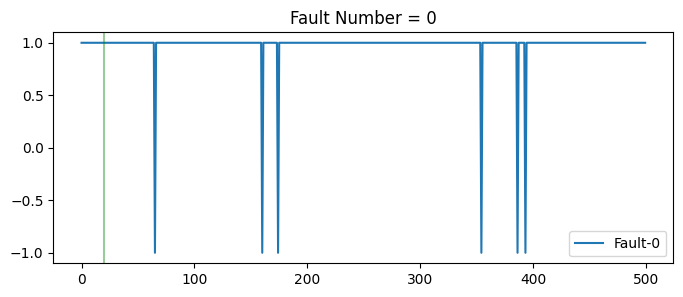

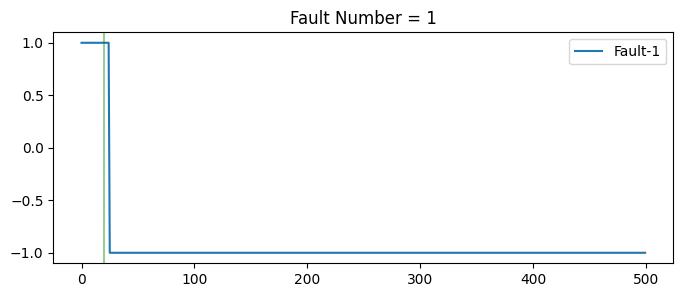

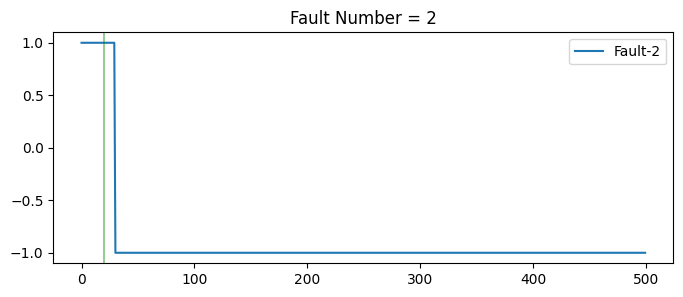

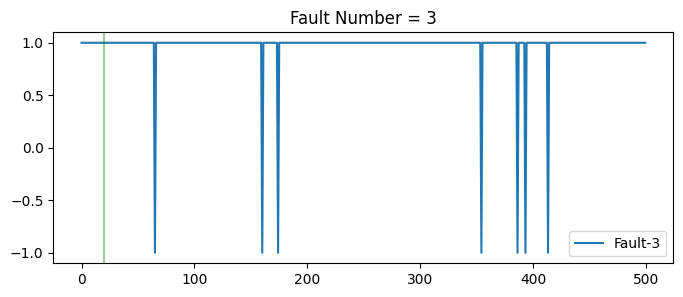

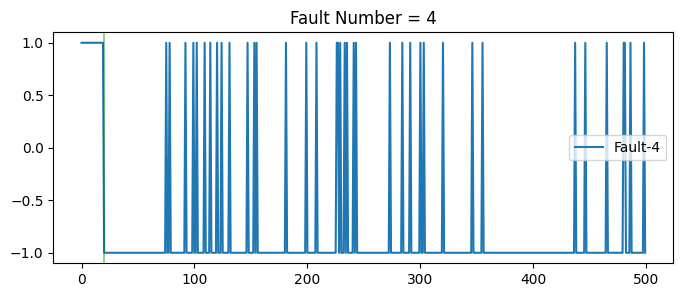

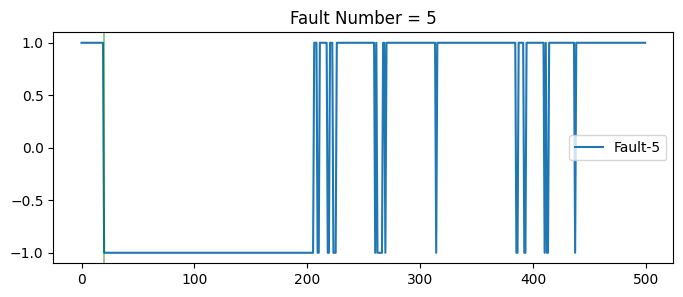

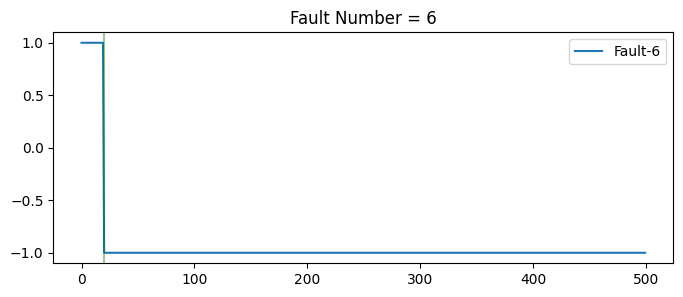

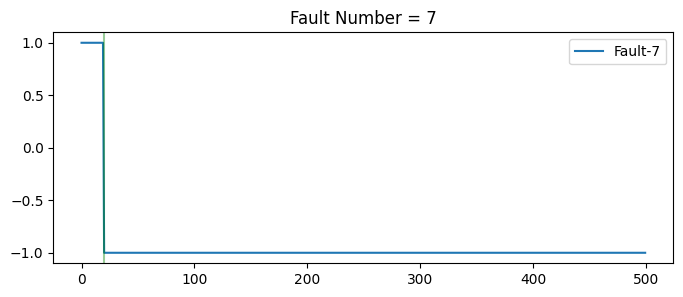

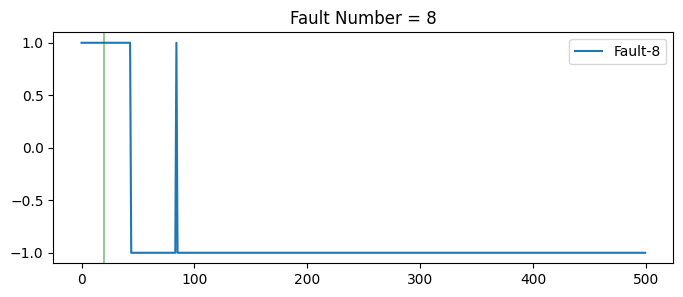

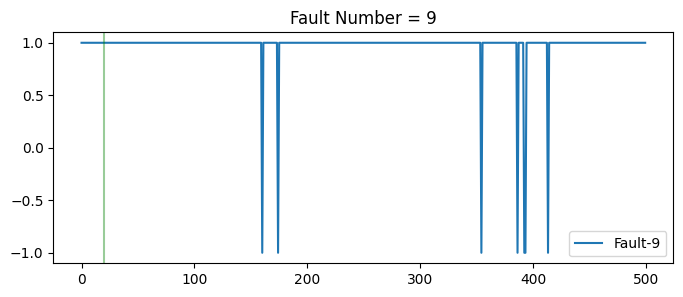

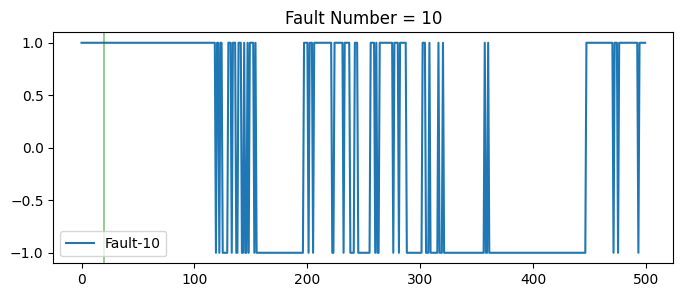

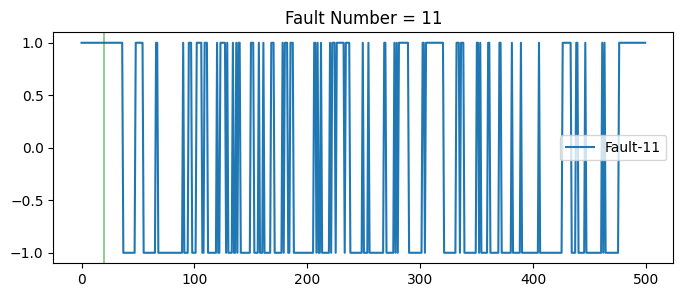

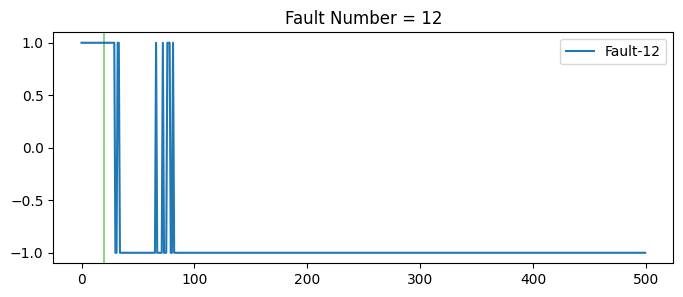

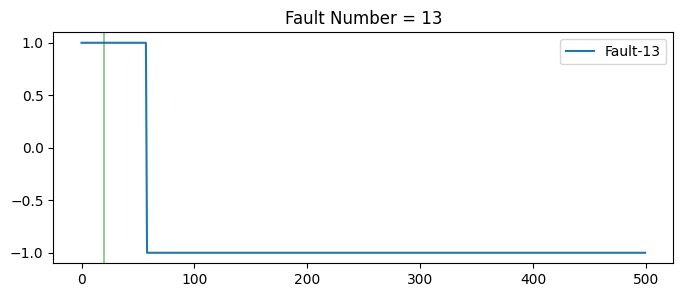

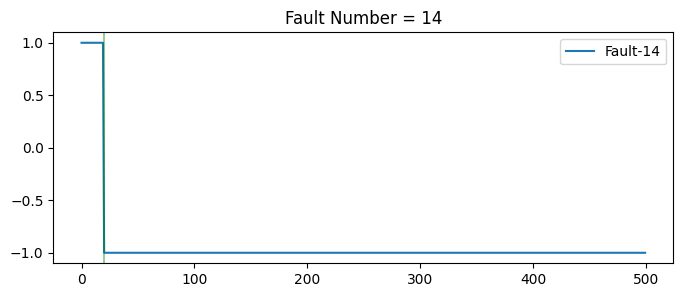

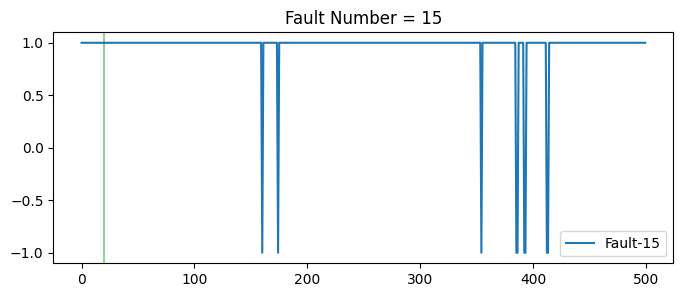

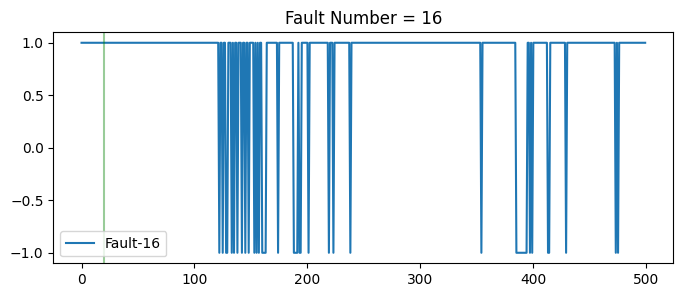

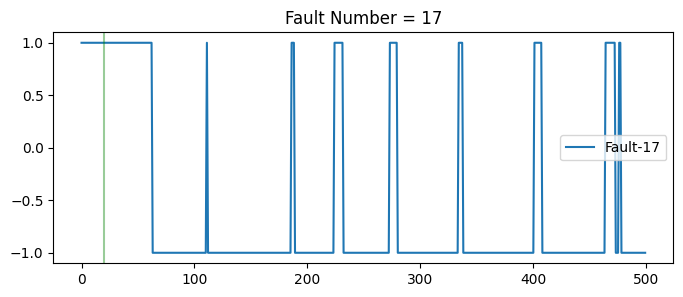

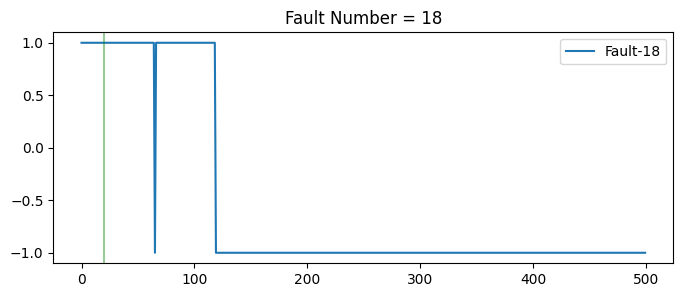

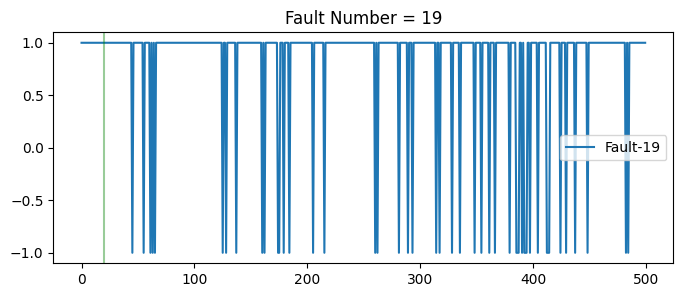

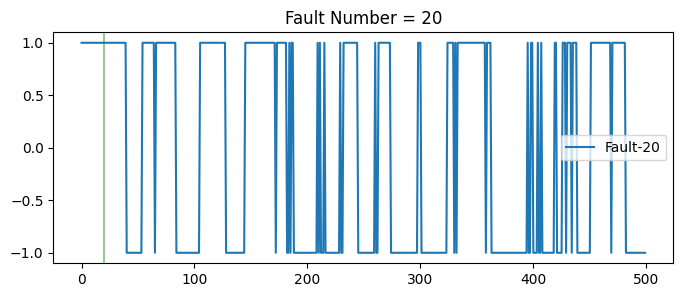

In [12]:

for F_num in range(0,21):
    # store the required fault class and simulation run
    temp = DF[(DF.faultNumber==F_num) & (DF.simulationRun==1 )]  #Faulty Condition
    # Standardization
    X_faulty = sc.transform(temp.iloc[:,3:])
    # Obtain distnace from the cluster's center
    anomaly_score = OneClassSVM.predict(X_faulty)

    plt.rcParams['figure.figsize'] = [8,3]
    plt.plot(anomaly_score ,label=f'Fault-{F_num}')
    plt.axvline(20,c='g',alpha=0.4) #time of fault introduction
    plt.title(f'Fault Number = {F_num}')
    plt.legend()
    plt.show()



# Evaluate F1 score to compare performance

In [13]:
def combine_result(x):
    # IF reconstruction loss is grater than threshold THEN its a fault
    result= x == -1
    result_float = [float(val) for val in result]
    return result_float

# Get the mean-F1 score of all types of faults from (0-21) for bench marking

In [14]:
F1_all = [] #initialize the emplty list of F1 score
Acc_all = []
for Fnum in [x for x in range(0,21) if x not in [3,9]]:

    temp_df = DF[ (DF['faultNumber']==Fnum) & (DF['simulationRun']==np.random.randint(1,500))]
    X_faulty = sc.transform(temp_df.iloc[:,3:])

    anomaly_score = OneClassSVM.predict(X_faulty)
    #populate the true value (y_true) based of Fnum
    y_pred = combine_result(anomaly_score)

    if Fnum==0:
        y_true = np.repeat(0, len(y_pred))
    else:
        y_true = np.repeat(1, len(y_pred))
        y_true[0:21]=0 # Beacuse the fault was introduced after 20th sample

    # Obtain F1 score
    from sklearn.metrics import f1_score,accuracy_score
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    F1_all.append(f1)
    Acc_all.append(acc)

print(f'The mean F1-Score for OC-SVM method is {np.mean(np.array(F1_all))}')
print(f'The mean Accuracy-Score for OC-SVM method is {np.mean(np.array(Acc_all))}')

The mean F1-Score for OC-SVM method is 0.6570554025523274
The mean Accuracy-Score for OC-SVM method is 0.7633684210526317
